In [13]:
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import jax
import optax

from jax import jacfwd

import matplotlib.pyplot as plt

In [14]:
import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'collocation'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from interpolation import BarycentricInterpolation

In [15]:
class SimpleNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(2)(x)  
        # 2D output for u and v
        return x

def create_model():
    model = SimpleNN()
    return model

def init_model_params(model, rng, input_shape):
    params = model.init(rng, jnp.ones(input_shape))
    return params

def model_forward(params, x):
    return SimpleNN().apply(params, x)


In [16]:
def create_train_state(rng, learning_rate, model, input_shape):
    params = init_model_params(model, rng, input_shape)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def compute_loss(params, batch):
    preds = model_forward(params, batch['inputs'])
    loss = jnp.mean((preds - batch['targets']) ** 2)
    return loss

@jax.jit
def train_step(state, batch):
    loss_fn = lambda params: compute_loss(params, batch)
    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state


In [17]:
def lagrange_basis(t, k, t_grid):
    terms = [(t - t_grid[m]) / (t_grid[k] - t_grid[m]) for m in range(len(t_grid)) if m != k]
    return jnp.prod(jnp.array(terms))


def interpolate(u, t, t_grid):
    """
    u: The array of function values at the grid points
    t: The point at which to interpolate
    t_grid: The array of interpolation nodes
    """
    if u.ndim == 1:
        return jnp.sum(jnp.array([u_k * lagrange_basis(t, k, t_grid) for k, u_k in enumerate(u)]))
    return jnp.array([jnp.sum(jnp.array([u_k[i] * lagrange_basis(t, k, t_grid) for k, u_k in enumerate(u)])) for i in range(u.shape[1])])


* where are we interpreting the params?

In [18]:
# Use the trained neural network as the function f
def neural_net_f(t, uv, params):
    return model_forward(params, uv)

# Modify the solver to pass the neural network parameters
def newton_method_nn(u_init, t_grid, f, params, u0=1, tol=1e-6, max_iter=20):
    """
    Solves a system of nonlinear equations using Newton's method with a neural network.
    
    Parameters:
    u_init : ndarray
        Initial guess for the solution.
    t_grid : ndarray
        Grid points where the solution is evaluated.
    f : function
        The function defining the system of differential equations.
    params : dict
        Trained parameters of the neural network.
    u0 : float or ndarray, optional
        Initial condition for the system (default is 1).
    tol : float, optional
        Tolerance for the norm of the update (default is 1e-6).
    max_iter : int, optional
        Maximum number of iterations (default is 100).
    
    Returns:
    ndarray
        The solution vector.
    
    Raises:
    ValueError
        If Newton's method did not converge.
    """
    u = u_init
    
    for i in range(max_iter):
        F_u = system(u, t_grid, f, u0, params)
        
        # Compute the Jacobian matrix of the system at u
        J_u = jacfwd(system, argnums=0)(u, t_grid, f, u0, params)
        
        # Flatten the Jacobian and F_u for solving
        F_u_flat = F_u.reshape(-1)
        J_u_flat = J_u.reshape(F_u_flat.shape[0], -1)
        
        # Solve for the update Δu in the linear system J(u) Δu = -F(u)
        delta_u_flat = jnp.linalg.solve(J_u_flat, -F_u_flat)
        
        # Reshape the update and apply
        delta_u = delta_u_flat.reshape(u.shape)
        u = u + delta_u
        
        norm_delta_u = jnp.linalg.norm(delta_u)
        if norm_delta_u < tol:
            print(f"Converged at iteration {i+1}")
            return u
    
    raise ValueError("Newton's method did not converge")

# Update system function to pass the neural network parameters
def system(u, t_grid, f, u0, params):
    u0 = jnp.array([1.0, 0.0])  # Initial condition u(0) = 1, v(0) = 0
    eqs = [u[0] - u0]
    
    for k in range(1, len(t_grid)):
        eq = u[k] - u[k-1] - integral(f, t_grid[k-1], t_grid[k], u, t_grid, params)
        eqs.append(eq)
    
    return jnp.array(eqs)

# Update integral function to pass the neural network parameters
def integral(f, t_k, t_k1, u, t_grid, params):
    integrand = lambda s: f(s, interpolate(u, s, t_grid), params)
    vectorized_integrand = jax.vmap(integrand)
    s_values = jnp.linspace(t_k, t_k1, 100)
    integrand_values = vectorized_integrand(s_values)
    integral_value = jnp.trapezoid(integrand_values, s_values, axis=0)
    return integral_value


In [12]:
omega = 2.0  # Frequency of the harmonic oscillator

def f_2(t, uv):
    # print(type(uv))
    u, v = uv
    return jnp.array([v, -omega**2 * u])

# Parameters
T = 4.0  # End time
N = 20  # Number of grid points

# Create the grid points
# t_grid = jnp.linspace(0, T, N)
interpolator = BarycentricInterpolation(N, start=0, stop=T)
t_grid = interpolator.nodes

# Initial guess for the solution
uv_init = jnp.ones((N, 2))  # Start with a non-zero initial guess
uv_init = uv_init.at[0, 1].set(0)  # Set the initial velocity to 0

u0=jnp.array([1.0, 0.0])

# def newton_method_nn(u_init, t_grid, f, params, u0=1, tol=1e-6, max_iter=20):

"""
But not passing params???
"""
uv_solution = newton_method_nn(uv_init, t_grid, f_2, u0)

print("Solution at grid points:", uv_solution)

NameError: name 'newton_method' is not defined

In [10]:
# Parameters
T = 2.0  # End time
N = 10  # Number of grid points
omega = 1

# Create the grid points
interpolator = BarycentricInterpolation(N, start=0, stop=T)
t_grid = interpolator.nodes

# Initial guess for the solution
uv_init = jnp.ones((N, 2))  # Start with a non-zero initial guess
uv_init = uv_init.at[0, 1].set(0)  # Set the initial velocity to 0

# Solve the system using the neural network
uv_solution_nn = newton_method_nn(uv_init, t_grid, neural_net_f, trained_params)

# Print the solution
print("Solution at grid points using neural network:", uv_solution_nn)

Converged at iteration 5
Solution at grid points using neural network: [[ 1.0000000e+00  5.1282763e-16]
 [ 1.0612332e+00 -5.8976107e-04]
 [ 1.2594595e+00 -3.5676914e-03]
 [ 1.6379030e+00 -1.3093015e-02]
 [ 2.2621729e+00 -3.7330229e-02]
 [ 3.1922195e+00 -8.7867968e-02]
 [ 4.4150267e+00 -1.7294604e-01]
 [ 5.7518787e+00 -2.8195208e-01]
 [ 6.8356633e+00 -3.7788475e-01]
 [ 7.2579813e+00 -4.1673976e-01]]


* this still needs to be refined?
* we are not really training the neural network?

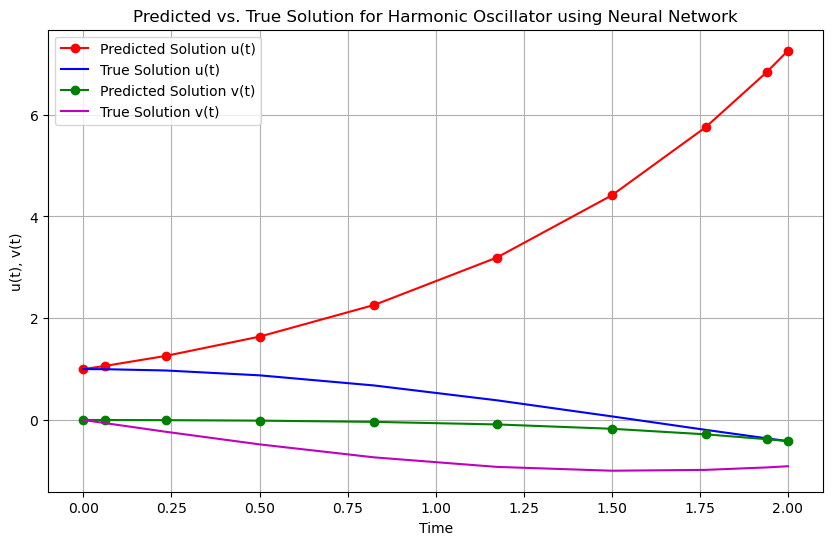

In [11]:
# Plot predicted vs. true solution
true_solution_u = jnp.cos(omega * t_grid)
true_solution_v = -omega * jnp.sin(omega * t_grid)

plt.figure(figsize=(10, 6))
plt.plot(t_grid, uv_solution_nn[:, 0], 'ro-', label='Predicted Solution u(t)')
plt.plot(t_grid, true_solution_u, 'b-', label='True Solution u(t)')
plt.plot(t_grid, uv_solution_nn[:, 1], 'go-', label='Predicted Solution v(t)')
plt.plot(t_grid, true_solution_v, 'm-', label='True Solution v(t)')
plt.xlabel('Time')
plt.ylabel('u(t), v(t)')
plt.legend()
plt.title('Predicted vs. True Solution for Harmonic Oscillator using Neural Network')
plt.grid(True)
plt.show()